In [ ]:
# =====================================
#  Step 1: Import Libraries & Dataset
# =====================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

# Load dataset
df = pd.read_csv("Titanic-Dataset.csv")

# Basic info
print("Original Shape:", df.shape)
print(df.info())
df.head()


Original Shape: (891, 12)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [ ]:
# =====================================
# Step 2: Handle Missing Values
# =====================================
# Check missing values
print(df.isnull().sum())

# Fill missing values
df['Age'] = df['Age'].fillna(df['Age'].median())                # Median for Age
df['Embarked'] = df['Embarked'].fillna(df['Embarked'].mode()[0]) # Mode for Embarked
df = df.drop(columns=['Cabin'])  # Drop Cabin due to too many nulls

print("After handling missing values:")
print(df.isnull().sum())


PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64
After handling missing values:
PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
dtype: int64


In [ ]:
# =====================================
#  Step 3: Encode Categorical Features
# =====================================
df = pd.get_dummies(df, columns=['Sex','Embarked'], drop_first=True)
df.head()


,PassengerId,Survived,Pclass,Name,Age,SibSp,Parch,Ticket,Fare,Sex_male,Embarked_Q,Embarked_S
0,1,0,3,"Braund, Mr. Owen Harris",22.0,1,0,A/5 21171,7.2500,True,False,True
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,1,0,PC 17599,71.2833,False,False,False
2,3,1,3,"Heikkinen, Miss. Laina",26.0,0,0,STON/O2. 3101282,7.9250,False,False,True
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.0,1,0,113803,53.1000,False,False,True
4,5,0,3,"Allen, Mr. William Henry",35.0,0,0,373450,8.0500,True,False,True


In [ ]:
# =====================================
#  Step 4: Convert Numerical Features to Natural Numbers
# =====================================

# First ensure Age has no missing values (use median fill)
df['Age'] = df['Age'].fillna(df['Age'].median())
df['Fare'] = df['Fare'].fillna(df['Fare'].median())

# Age bins (0 = child, 1 = teen, 2 = young adult, 3 = middle-aged, 4 = senior)
df['AgeGroup'] = pd.cut(df['Age'], 
                        bins=[-1, 12, 18, 35, 50, 100], 
                        labels=[0,1,2,3,4])  # natural numbers

# Fare bins (quartiles → 0,1,2,3)
df['FareGroup'] = pd.qcut(df['Fare'], 4, labels=[0,1,2,3])

# Convert categories to integers
df['AgeGroup'] = df['AgeGroup'].astype(int)
df['FareGroup'] = df['FareGroup'].astype(int)

# Drop original continuous columns if only groups are needed
df = df.drop(columns=['Age','Fare'])

df[['AgeGroup','FareGroup']].head(10)


,AgeGroup,FareGroup
0,2,0
1,3,3
2,2,1
3,2,3
4,2,1
5,2,1
6,4,3
7,0,2
8,2,1
9,1,2


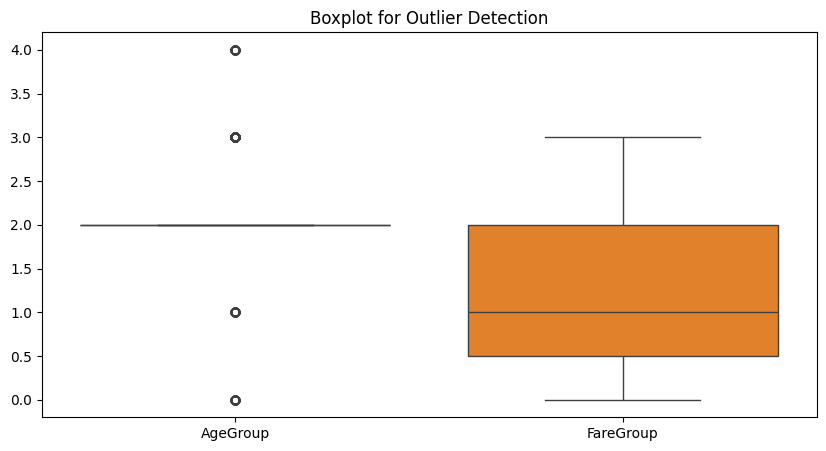

Shape after outlier removal: (669, 12)


In [ ]:
# =====================================
#  Step 5: Outlier Detection & Removal
# =====================================
plt.figure(figsize=(10,5))
sns.boxplot(data=df[['AgeGroup','FareGroup']])
plt.title("Boxplot for Outlier Detection")
plt.show()

# Remove extreme outliers (top 1% Fare)
df = df[df['FareGroup'] < df['FareGroup'].quantile(0.99)]
print("Shape after outlier removal:", df.shape)


In [ ]:
# =====================================
#  Step 6: Feature Engineering 
# =====================================

# 1. Extract Title from Name
df['Title'] = df['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
df['Title'] = df['Title'].replace(['Lady','Countess','Capt','Col','Don','Dr',
                                   'Major','Rev','Sir','Jonkheer','Dona'],'Rare')
df['Title'] = df['Title'].replace({'Mlle':'Miss','Ms':'Miss','Mme':'Mrs'})

# 2. Family features
df['FamilySize'] = df['SibSp'] + df['Parch'] + 1
df['IsAlone'] = (df['FamilySize'] == 1).astype(int)

# 3. Age Group (if Age column exists)
if 'Age' in df.columns:
    df['Age'] = df['Age'].fillna(df['Age'].median())
    df['AgeGroup'] = pd.cut(df['Age'], 
                            bins=[-1, 12, 18, 35, 50, 100], 
                            labels=[0,1,2,3,4]).astype(int)

# 4. Fare Group (if Fare column exists)
if 'Fare' in df.columns:
    df['Fare'] = df['Fare'].fillna(df['Fare'].median())
    df['FareGroup'] = pd.qcut(df['Fare'], 4, labels=[0,1,2,3], duplicates='drop').astype(int)

# 5. Encode Title
df = pd.get_dummies(df, columns=['Title'], drop_first=True)

# Final check (only display what exists)
cols_to_show = [c for c in ['Age','AgeGroup','Fare','FareGroup','FamilySize','IsAlone'] if c in df.columns]
print(df[cols_to_show].head(10))



In [23]:
df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'SibSp', 'Parch', 'Ticket',
       'Sex_male', 'Embarked_Q', 'Embarked_S', 'AgeGroup', 'FareGroup',
       'Title', 'FamilySize', 'IsAlone', 'AgeBin'],
      dtype='object')